# Pricing Down-and-In Barrier European Call Option in the Heston Model

## Change working directory to navigate out of folder. 

In [1]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

## Load Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
import pandas as pd
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
import torch.cuda
from collections import defaultdict

from IPython.display import display, HTML

from GenerateMMDDataset.mmd_dataset_base import save_dataset, load_dataset, save_path_params, load_path_params

from RegressionModel.pricing_model import PricingModel
from RegressionModel.mmd_model import SecondOrderMMDApprox

from utils.plotting_functions import construct_scatter_plot

from StochasticModels.geometric_brownian_motion import BlackScholesExactSimulationSobolNDim_autocallable, ConstantCorrelationCov 

## Set PyTorch Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
torch.backends.cudnn.benchmark = True

Device: cuda


## Autocallable Payoff

In [15]:
def indicator_fn(x, y):
    '''
    Indicator function.
    :param x: first variable. 
    :param y: second variable. 
    :return: 1 if x <= y, otherwise 0. 
    '''
    
    return 1 if x <= y else 0


def autocallable_payoff(S, S_ref, N, T_end, B_gar, B_coup, B_call, R, delta, i, lookup):
    '''
    Autocallable payoff at fixing date T_{i}.
    :param S: Time-series of assets values. 
    :param S_ref: List of normalising values. 
    :param N: List of notionals. 
    :param T_end: Final fixing date. 
    :param B_gar: Capital guarantee barrier level. 
    :param B_coup: Performance barrier level.
    :param B_call: Early termination barrier level. 
    :param R: Rebate. 
    :param delta: Time between fixing dates. 
    :param i: Current fixing date. 
    :param lookup: Dictionary of payoff values at fixing dates. Keys are fixing dates. 
    '''
    
    dim = len(S_ref)

    P_t = lambda t: min([S[t][i] / S_ref[i] for i in range(dim)])

    delta_i = lambda j: 1 if i == T_end else 0

    tau = T_end + 1
    for j in range(1, int(T_end / delta) + 1):
        if P_t(j) >= B_call:
            tau = j
            break
    
    payoff_w_rebate_w_lookup = (1 - indicator_fn(tau, i)) * ((N[i - 1] + np.sum(
        [N[j - 1] - lookup[j] if j in lookup.keys()
         else N[j - 1] - autocallable_payoff(S, S_ref, N, T_end, B_gar, B_coup, B_call, R, delta, j, lookup)
         for j in range(1, i)])) * (1 - indicator_fn(P_t(i), B_coup)) + (delta_i(i * delta) * (P_t(-1) - 1) *
                                                                         indicator_fn(P_t(-1), B_gar)))

    rebate = R if tau == i else 0

    if i not in lookup.keys():
        lookup[i] = payoff_w_rebate_w_lookup + rebate

    if i == T_end:
        payoff_mat = 0
        for j in range(1, T_end+1):
            payoff_mat += np.exp(-r*j) * lookup[j]
        return payoff_mat
    
    return payoff_w_rebate_w_lookup + rebate
    

In [16]:
def price_autocallable_mc(S0, r, sigmas, correlation, S_ref, N, T_end, B_gar, B_coup, B_call, R, delta, num_sim):
    
    """
    Price autocallables using Monte Carlo (without discounting). 
    :param S0: List of initial spot values. 
    :param r: Risk-free interest rate. 
    :param sigma: List of volatilities. 
    :param correlation: Correlation value. 
    :param S_ref: List of normalising values. 
    :param N: List of notionals. 
    :param T_end: Final fixing date. 
    :param B_gar: Capital guarantee barrier level. 
    :param B_coup: Performance barrier level.
    :param B_call: Early termination barrier level. 
    :param R: Rebate. 
    :param delta: Time between fixing dates. 
    :param num_sim: Number of Monte Carlo simulations. 
    :return Autocallable price. 
    """    
        
    cov = ConstantCorrelationCov(sigmas, correlation)
    paths = BlackScholesExactSimulationSobolNDim_autocallable(S0, r, sigmas, cov, T_end, num_sim, delta)

    payoffs = []

    for i in range(num_sim):

        payoffs.append(autocallable_payoff(paths[:, i, :], S_ref, N, T_end, B_gar, B_coup, B_call, R, delta, int(T_end/delta), {}))

    return np.mean(payoffs)

## Load Pre-Trained MMD Model

In [17]:
multi_gbm_mmd_input_dimension = 8

multi_gbm_mmd_model_param_dict = {
    'input_dimension' : multi_gbm_mmd_input_dimension,
    'intermediate_dimensions' : [30, 30, 30, 30],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None
}

multi_gbm_second_order_mmd_model = SecondOrderMMDApprox(multi_gbm_mmd_model_param_dict, 
                                                        None,
                                                        None, None, device,
                                                        'Multi GBM/MMD Model/multi_gbm_mmd_scaler_1.pkl')

multi_gbm_second_order_mmd_model.load_best_model('Multi GBM/MMD Model/multi_gbm_mmd_model_best_1.pth.tar', 
                                                 'Multi GBM/MMD Model/multi_gbm_mmd_scaler_1.pkl')

## Generate Dataset

In [19]:
corr_range = (0.05, 0.95)
M = 50000
N = 20


S0_range = [100, 75, 69]
S_ref = [78, 60, 78]
r = 0.015


delta = 1
T_end = 5

dim = 3

S0_multi_gbm = [np.random.randint(80, 100, dim) for _ in range(M)]

S_ref_multi_gbm  = [np.random.randint(60, 85, dim) for _ in range(M)]

multi_gbm_sigma_list = [np.round(np.random.uniform(0.2, 0.8, dim), 5) for _ in range(M)]
multi_gbm_correlations = np.round(np.random.uniform(corr_range[0], corr_range[1], M), 5)

Notional_list = [np.round(np.random.uniform(20, 30, 5), 2) for _ in range(M)]
R_list = np.round(np.random.uniform(5, 15, M), 2)



autocallable_b_gar = np.round(np.random.uniform(0.2, 0.6, M), 5)
autocallable_b_coup = np.round(np.random.uniform(0.4, 0.8, M), 5)
autocallable_b_call = np.round(np.random.uniform(0.7, 2, M), 5)

MC_Num_Sim = 50000

autocallable_features = []
autocallable_labels = []


multi_gbm_second_order_mmd_model.model.eval()
with torch.no_grad():
    for i in tqdm(range(M)):      
        
        
        correlation = multi_gbm_correlations[i]
        sigmas = multi_gbm_sigma_list[i]        
        B_gar = autocallable_b_gar[i]
        B_coup = autocallable_b_coup[i]
        B_call = autocallable_b_call[i]
        S0 = S0_multi_gbm[i]
        S_ref = S_ref_multi_gbm[i]
        
        R = R_list[i]
        
        Notionals = Notional_list[i]

        
        new_features = []
        for j in range(N):
            mmd_input = [sigmas[int(k/2)] if k%2 == 0 else multi_gbm_sigma_list[j][int(k/2)] for k in range(2*dim)]
            mmd_input += [correlation, multi_gbm_correlations[j]]
            new_features.append(multi_gbm_second_order_mmd_model.transform(torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))
        
        for i in range(dim):
            new_features.append(S0[i])
            new_features.append(S_ref[i])
            
        for i in range(int(T_end/delta)):
            new_features.append(Notionals[i])
        
        new_features.append(R)
        
        new_features.append(B_gar)
        new_features.append(B_coup)
        new_features.append(B_call)

        autocallable_features.append(new_features)
        
        autocallable_labels.append(price_autocallable_mc(S0, r, sigmas, correlation, S_ref, Notionals, T_end, B_gar, B_coup, B_call, R, delta, MC_Num_Sim))

  0%|          | 0/50000 [00:00<?, ?it/s]

## Save Dataset

In [21]:
length = len(autocallable_features)
l = int(length/5)
sub_features = []
for i in range(5):
    sub_features.append(autocallable_features[i*l:(i+1)*l])
    
features_file_name_base = "Multi GBM/Data/multi_gbm_autocallable_features"

for i in range(5):
    with open(f'{features_file_name_base}_part_{i+1}', "wb") as fp:
        pickle.dump(sub_features[i], fp)
    
with open("Multi GBM/Data/multi_gbm_autocallable_labels", "wb") as fp:
    pickle.dump(autocallable_labels, fp)
    

multi_gbm_autocallable_dict = {
    'M' : M,
    'N' : N,
    'S0 Range' : S0_range, 
    'S0' : S0_multi_gbm,
    'r' : r,
    'Dim' : dim, 
    'Sigma List' : multi_gbm_sigma_list,
    'Correlation List' : multi_gbm_correlations,
    'Sigma Range' : (0.2, 0.8),
    'Correlation Range' : corr_range,
    'Num Sim' : MC_Num_Sim,
    'Delta' : delta,
    'T_end' : T_end,
    'Notionals' : Notional_list,
    'Notionals Range' : (20, 30),
    'Rebates' : R_list,
    'Rebate Range' : (5, 15),
    'B_gar' : autocallable_b_gar, 
    'B_coup' : autocallable_b_coup,
    'B_call' : autocallable_b_call, 
    'S_ref' : S_ref_multi_gbm,
    'S_ref Range' : (60, 85)
}
    
save_path_params(multi_gbm_autocallable_dict, "Multi GBM/Data/multi_gbm_autocallable_dict")

## Load Dataset

In [3]:
features_file_name_base = "Multi GBM/Data/multi_gbm_autocallable_features"
autocallable_features = []

for i in range(5):
    with open(f'{features_file_name_base}_part_{i+1}', 'rb') as f:
            autocallable_features += pickle.load(f)
        
with open("Multi GBM/Data/multi_gbm_autocallable_labels", 'rb') as f:
        autocallable_labels = pickle.load(f)
        
multi_gbm_autocallable_dict = load_path_params("Multi GBM/Data/multi_gbm_autocallable_dict")

### Scale the training labels. 

### Note: this is needed to testing and running the model. 

In [34]:
with open("Multi GBM/Data/multi_gbm_autocallable_labels", 'rb') as f:
        autocallable_labels = pickle.load(f)

label_mean = np.mean(autocallable_labels)
std_dev_label = np.std(autocallable_labels)
scaled_labels = np.divide(np.subtract(autocallable_labels, label_mean), std_dev_label)

### Train SPEEDRS

In [ ]:
multi_gbm_autocallable_training_param_dict = {
    'lr' : 0.005,
    'Epochs' : 200,
    'l2_weight' : 0.0,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}

multi_gbm_autocallable_dataset_loader_params = {
    'batch_size' : 256,
    'shuffle' : True,
    'num_workers' : 0
}

dim = 3

for k in [1, 5, 10, 15, 20]:
    
    N = k
    multi_gbm_autocallable_input_dimension = k+15


    multi_gbm_autocallable_model_param_dict = {
        'input_dimension' : multi_gbm_autocallable_input_dimension,
        'intermediate_dimensions' : [100, 100, 100, 100],
        'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
        'add_layer_norm' : [False, False, False, False, False], 
        'output_dimension' : 1,
        'output_activation_fn' : None,
        'use_input_layer_norm' : False,
        'use_output_layer_norm' : True,
        'use_residual' : False
    }
    
    for i in range(5):
        
    
        autocallable_pricing_model = PricingModel(multi_gbm_autocallable_model_param_dict, 
                                                multi_gbm_autocallable_training_param_dict, 
                                                multi_gbm_autocallable_dataset_loader_params, nn.MSELoss(), device,
                                                f'Multi GBM/Autocallable Pricer/autocallable_pricer_scaler_{k}_dist_{i+1}.pkl', 
                                                multi_gbm_autocallable_input_dimension, 
                                                scheduler_gamma=0.65, use_scheduler=True, 
                                                milestones=[15, 30, 50, 70, 90, 100, 110, 120, 130, 135, 140, 145, 150, 155,
                                                            160, 170, 180, 190])

        autocallable_pricing_model.fit(torch.tensor(autocallable_features).float()[:, 20-k:], 
                                     torch.tensor(np.squeeze(scaled_labels)).float(), 
                                     **{'filename' : f'Multi GBM/Autocallable Pricer/autocallable_pricer_checkpoint_{k}_dist_{i+1}.pth.tar', 
                                        'best_model_filename' : f'Multi GBM/Autocallable Pricer/autocallable_pricer_model_best_{k}_dist_{i+1}.pth.tar'})

In [14]:
train_losses_dict = defaultdict(list)

for k in [1, 5, 10, 15, 20]:
    
    for i in range(5):
        checkpoint = torch.load(f'Multi GBM/Autocallable Pricer/autocallable_pricer_model_best_{k}_dist_{i+1}.pth.tar', map_location='cpu')
        train_losses_dict[k].append(checkpoint['train_loss'])
    print(f'{"*"*20}  {k} {"*"*20}')
    print(np.mean(train_losses_dict[k]))
    print(np.std(train_losses_dict[k]))

********************  1 ********************
0.1969215154647827
0.002787158418694833
********************  5 ********************
0.0018011652398854494
0.00026947368009446376
********************  10 ********************
0.00034865060006268324
6.553158063442904e-05
********************  15 ********************
0.00030253344448283315
2.585017798477817e-05
********************  20 ********************
0.00028218957013450565
2.3602249270927123e-05


In [10]:
valid_losses_dict = defaultdict(list)

for k in [20]:
    
    for i in range(5):
        checkpoint = torch.load(f'Multi GBM/Autocallable Pricer/autocallable_pricer_model_best_new_{k}_dist_50000_v6_{i+1}.pth.tar', map_location='cpu')
        valid_losses_dict[k].append(checkpoint['valid_loss'])
    print(f'{"*"*20}  {k} {"*"*20}')
    print(np.mean(valid_losses_dict[k]))
    print(np.std(valid_losses_dict[k]))

********************  20 ********************
0.0006331044714897871
1.9439758122800477e-05


In [11]:
valid_losses_dict = defaultdict(list)

for k in [1, 5, 10, 15, 20]:
    
    for i in range(5):
        checkpoint = torch.load(f'Multi GBM/Autocallable Pricer/autocallable_pricer_model_best_{k}_dist_{i+1}.pth.tar', map_location='cpu')
        valid_losses_dict[k].append(checkpoint['valid_loss'])
    print(f'{"*"*20}  {k} {"*"*20}')
    print(np.mean(valid_losses_dict[k]))
    print(np.std(valid_losses_dict[k]))

********************  1 ********************
0.20094211995601655
0.002570202804318492
********************  5 ********************
0.004888936597853899
0.00014589224966846226
********************  10 ********************
0.0008974692551419139
3.9058595372481606e-05
********************  15 ********************
0.0007430387195199728
2.1021231836076555e-05
********************  20 ********************
0.0006331044714897871
1.9439758122800477e-05


### Train Baseline

In [ ]:
multi_gbm_rainbow_best_call_diff_k_training_param_dict_no_dist = {
    'lr' : 0.005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}

multi_gbm_rainbow_best_call_dataset_diff_k_loader_params_no_dist = {
    'batch_size' : 256,
    'shuffle' : True,
    'num_workers' : 0
}


multi_gbm_rainbow_best_call_diff_K_input_dimension_no_dist = 19


multi_gbm_rainbow_best_call_model_param_diff_K_dict_no_dist = {
    'input_dimension' : multi_gbm_rainbow_best_call_diff_K_input_dimension_no_dist,
    'intermediate_dimensions' : [30, 30, 30, 30],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}

multi_gbm_sigma_list = multi_gbm_autocallable_dict['Sigma List']
multi_gbm_correlations = multi_gbm_autocallable_dict['Correlation List']

new_features = []
for i in range(len(autocallable_features)):
    new_features.append(multi_gbm_sigma_list[i].tolist() + [multi_gbm_correlations[i]] + autocallable_features[i][20:])

for i in range(5):
    
    autocallable_pricing_modell_no_dist = PricingModel(multi_gbm_rainbow_best_call_model_param_diff_K_dict_no_dist, 
                                            multi_gbm_rainbow_best_call_diff_k_training_param_dict_no_dist, 
                                            multi_gbm_rainbow_best_call_dataset_diff_k_loader_params_no_dist, nn.MSELoss(), device,
                                            f'Multi GBM/Autocallable Pricer/autocallable_pricer_scaler_no_dist_{i+1}.pkl', 
                                            multi_gbm_rainbow_best_call_diff_K_input_dimension_no_dist, 
                                            scheduler_gamma=0.75, use_scheduler=True, 
                                            milestones=[50, 70, 90, 100, 110, 120, 130, 135, 140, 145, 150, 155,
                                                        160, 165, 170, 175, 180, 185, 190, 195])
    
    autocallable_pricing_modell_no_dist.fit(torch.tensor(new_features).float(), 
                                 torch.tensor(np.squeeze(scaled_labels)).float(), 
                                 **{'filename' : f'Multi GBM/Autocallable Pricer/autocallable_pricer_checkpoint_no_dist_{i+1}.pth.tar', 
                                    'best_model_filename' : f'Multi GBM/Autocallable Pricer/autocallable_pricer_model_best_no_dist_{i+1}.pth.tar'})

In [9]:
train_losses = []
valid_losses = []
    
for i in range(5):
    checkpoint = torch.load(f'Multi GBM/Autocallable Pricer/autocallable_pricer_model_best_no_dist_{i+1}.pth.tar', map_location='cpu')
    train_losses.append(checkpoint['train_loss'])
    valid_losses.append(checkpoint['valid_loss'])

print(f'Training Loss')
print(np.mean(train_losses))
print(np.std(train_losses))
print(f'Validation Loss')
print(np.mean(valid_losses))
print(np.std(valid_losses))

Training Loss
0.000640918652061373
2.0762414196821822e-05
Validation Loss
0.0007690400001592934
2.27088336117679e-05


## Test the model

In [ ]:
with open("Multi GBM/Data/multi_gbm_autocallable_labels", 'rb') as f:
        autocallable_labels = pickle.load(f)

label_mean = np.mean(autocallable_labels)
std_dev_label = np.std(autocallable_labels)
scaled_labels = np.divide(np.subtract(autocallable_labels, label_mean), std_dev_label)

In [22]:
corr_range = (0.05, 0.95)
M = 2000
N = 20


S0_range = [100, 75, 69]
S_ref = [78, 60, 78]
r = 0.015


delta = 1
T_end = 5

dim = 3

S0_multi_gbm = [np.random.randint(80, 100, dim) for _ in range(M)]

S_ref_multi_gbm  = [np.random.randint(60, 85, dim) for _ in range(M)]

multi_gbm_sigma_list = [np.round(np.random.uniform(0.2, 0.8, dim), 5) for _ in range(M)]
multi_gbm_correlations = np.round(np.random.uniform(corr_range[0], corr_range[1], M), 5)

Notional_list = [np.round(np.random.uniform(20, 30, 5), 2) for _ in range(M)]
R_list = np.round(np.random.uniform(5, 15, M), 2)



autocallable_b_gar = np.round(np.random.uniform(0.2, 0.6, M), 5)
autocallable_b_coup = np.round(np.random.uniform(0.4, 0.8, M), 5)
autocallable_b_call = np.round(np.random.uniform(0.7, 2, M), 5)

MC_Num_Sim = 50000

autocallable_labels_test = []


multi_gbm_second_order_mmd_model.model.eval()
for i in tqdm(range(M)):      
         
    correlation = multi_gbm_correlations[i]
    sigmas = multi_gbm_sigma_list[i]        
    B_gar = autocallable_b_gar[i]
    B_coup = autocallable_b_coup[i]
    B_call = autocallable_b_call[i]
    S0 = S0_multi_gbm[i]
    S_ref = S_ref_multi_gbm[i]

    R = R_list[i]

    Notionals = Notional_list[i]

    autocallable_labels_test.append(price_autocallable_mc(S0, r, sigmas, correlation, S_ref, Notionals, T_end, B_gar, B_coup, B_call, R, delta, MC_Num_Sim))

  0%|          | 0/2000 [00:00<?, ?it/s]

In [23]:
with open("Multi GBM/Data/TEST_multi_gbm_autocallable_labels", "wb") as fp:
    pickle.dump(autocallable_labels_test, fp)
    

multi_gbm_autocallable_dict_test = {
    'M' : M,
    'N' : N,
    'S0 Range' : S0_range, 
    'S0' : S0_multi_gbm,
    'r' : r,
    'Dim' : dim, 
    'Sigma List' : multi_gbm_sigma_list,
    'Correlation List' : multi_gbm_correlations,
    'Sigma Range' : (0.2, 0.8),
    'Correlation Range' : corr_range,
    'Num Sim' : MC_Num_Sim,
    'Delta' : delta,
    'T_end' : T_end,
    'Notionals' : Notional_list,
    'Notionals Range' : (20, 30),
    'Rebates' : R_list,
    'Rebate Range' : (5, 15),
    'B_gar' : autocallable_b_gar, 
    'B_coup' : autocallable_b_coup,
    'B_call' : autocallable_b_call, 
    'S_ref' : S_ref_multi_gbm,
    'S_ref Range' : (60, 85)
}
    
save_path_params(multi_gbm_autocallable_dict_test, "Multi GBM/Data/multi_gbm_autocallable_dict_TEST")

### SPEEDRS

In [42]:
multi_gbm_autocallable_dict_test = load_path_params("Multi GBM/Data/multi_gbm_autocallable_dict_TEST")

feature_vecs = []

multi_gbm_second_order_mmd_model.model.eval()
with torch.no_grad():
    for i in tqdm(range(M)):  
        
        
        correlation = multi_gbm_autocallable_dict_test['Correlation List'][i]
        sigmas = multi_gbm_autocallable_dict_test['Sigma List'][i]        
        B_gar = multi_gbm_autocallable_dict_test['B_gar'][i]
        B_coup = multi_gbm_autocallable_dict_test['B_coup'][i]
        B_call = multi_gbm_autocallable_dict_test['B_call'][i]
        S0 = multi_gbm_autocallable_dict_test['S0'][i]
        S_ref = multi_gbm_autocallable_dict_test['S_ref'][i]
        
        R = multi_gbm_autocallable_dict_test['Rebates'][i]
        
        Notionals = multi_gbm_autocallable_dict_test['Notionals'][i]
        
            
        new_features = []
        for j in range(N):
            
            mmd_input = [sigmas[int(k/2)] if k%2 == 0 else multi_gbm_autocallable_dict['Sigma List'][j][int(k/2)]
                         for k in range(2*dim)]
            mmd_input += [correlation, multi_gbm_autocallable_dict['Correlation List'][j]]
            new_features.append(multi_gbm_second_order_mmd_model.transform(torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))

        
        for i in range(dim):
            new_features.append(S0[i])
            new_features.append(S_ref[i])
            
        for i in range(int(T_end/delta)):
            new_features.append(Notionals[i])
        
        new_features.append(R)
        
        new_features.append(B_gar)
        new_features.append(B_coup)
        new_features.append(B_call)

        feature_vecs.append(new_features)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [73]:
test_losses_dict = defaultdict(list)


scaled_labels = np.divide(np.subtract(autocallable_labels_test, label_mean), std_dev_label)


for k in [1, 5, 10, 15, 20]:
    
    input_dimension = k+15

    architecture = {
        'input_dimension' : input_dimension,
        'intermediate_dimensions' : [100, 100, 100, 100],
        'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], # List of length equal to the number of hidden units
        'add_layer_norm' : [False, False, False, False, False], # List of length equal to 1 - Num. Hidden Units
        'output_dimension' : 1,
        'output_activation_fn' : None,
        'use_input_layer_norm' : False,
        'use_output_layer_norm' : True,
        'use_residual' : False
    }

    
    pricing_model = PricingModel(architecture,
                                 None,
                                 None,
                                 None,
                                 device, 
                                 None,
                                 input_dimension)
    
        
    for i in range(5):

        pricing_model.load_best_model(f'Multi GBM/Autocallable Pricer/autocallable_pricer_model_best_{k}_dist_{i+1}.pth.tar', 
                                      f'Multi GBM/Autocallable Pricer/autocallable_pricer_scaler_{k}_dist_{i+1}.pkl')
 
        
        features = torch.tensor(feature_vecs).float()[:, 20-k:]
        pricing_model.model.eval()
        with torch.no_grad():
            prices = pricing_model.transform(features).cpu()
            test_losses_dict[k].append(mean_squared_error(prices, scaled_labels))
        
    print(f'{"*"*20}  {k} {"*"*20}')
    print(np.mean(test_losses_dict[k]))
    print(np.std(test_losses_dict[k]))

********************  1 ********************
0.1944081133980074
0.0015777414396031988
********************  5 ********************
0.01214275362532467
0.00028208542799110556
********************  10 ********************
0.008352788753930163
6.315222750577664e-05
********************  15 ********************
0.008112055823907829
0.00011728518542052573
********************  20 ********************
0.00792605680034798
0.00012269246654415445


### Baseline

In [80]:
input_dimension = 19


architecture = {
    'input_dimension' : input_dimension,
    'intermediate_dimensions' : [30, 30, 30, 30],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()],
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}


new_features = []
for i in range(len(autocallable_features)):
    new_features.append(multi_gbm_autocallable_dict_test['Sigma List'][i].tolist() + 
                        [multi_gbm_autocallable_dict_test['Correlation List'][i]] + 
                        feature_vecs[i][20:])



test_losses = []

for i in range(5):
    
    pricing_model = PricingModel(architecture,
                                 None,
                                 None,
                                 None,
                                 device, 
                                 None,
                                 input_dimension)

    pricing_model.load_best_model(f'Multi GBM/Autocallable Pricer/autocallable_pricer_model_best_no_dist_{i+1}.pth.tar', 
                                  f'Multi GBM/Autocallable Pricer/autocallable_pricer_scaler_no_dist_{i+1}.pkl')

    
    pricing_model.model.eval()
    with torch.no_grad():
        prices = pricing_model.transform(torch.tensor(new_features).float()).cpu()
        test_losses.append(mean_squared_error(prices, scaled_labels))
        
print(np.mean(test_losses))
print(np.std(test_losses))

0.008110440377220602
0.0001459470211765828


### SPEEDRS - Out of Sample Tests

In [18]:
input_dimension = 20+15
N = 20

architecture = {
    'input_dimension' : input_dimension,
    'intermediate_dimensions' : [100, 100, 100, 100],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], # List of length equal to the number of hidden units
    'add_layer_norm' : [False, False, False, False, False], # List of length equal to 1 - Num. Hidden Units
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}


autocallable_pricing_model = PricingModel(architecture,
                                          None,
                                          None,
                                          None,
                                          device, 
                                          None,
                                          input_dimension)




autocallable_pricing_model.load_best_model(
    'Multi GBM/Autocallable Pricer/autocallable_pricer_model_best_20_dist_5.pth.tar',
    'Multi GBM/Autocallable Pricer/autocallable_pricer_scaler_20_dist_5.pkl')


input_dimension = 19


architecture = {
    'input_dimension' : input_dimension,
    'intermediate_dimensions' : [30, 30, 30, 30],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()],
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}

autocallable_pricing_modell_no_dist = PricingModel(architecture,
                                                   None,
                                                   None,
                                                   None,
                                                   device, 
                                                   None,
                                                   input_dimension)


autocallable_pricing_modell_no_dist.load_best_model(
    'Multi GBM/Autocallable Pricer/autocallable_pricer_model_best_no_dist_1.pth.tar',
    'Multi GBM/Autocallable Pricer/autocallable_pricer_scaler_no_dist_1.pkl')


multi_gbm_autocallable_dict = load_path_params("Multi GBM/Data/multi_gbm_autocallable_dict")

with open("Multi GBM/Data/multi_gbm_autocallable_labels", 'rb') as f:
        autocallable_labels = pickle.load(f)

label_mean = np.mean(autocallable_labels)
std_dev_label = np.std(autocallable_labels)
scaled_labels = np.divide(np.subtract(autocallable_labels, label_mean), std_dev_label)

test_data_dict = {}

- Vary $B_{\mathrm{call}}$ and keep the other parameters fixed. 

In [23]:
dim = 3

correlation = np.round(np.random.uniform(0.05, 0.95), 5)
sigmas = np.round(np.random.uniform(0.2, 0.8, dim), 5)
S0 = np.random.randint(80, 100, dim)
S_ref = np.random.randint(60, 85, dim)
r = 0.015
delta = 1
T_end = 5
Notionals = np.round(np.random.uniform(20, 30, 5), 2)
R = np.round(np.random.uniform(5, 15), 2)
B_coup = np.round(np.random.uniform(0.4, 0.8), 5)
B_gar = np.round(np.random.uniform(0.2, 0.6), 5)
B_call_list = np.round(np.linspace(0.7, 2, 20), 5)


MC_Num_Sim = 50000

approximate_prices = []
autocallable_monte_carlo_prices_B_call = []

no_dist_prices = []


multi_gbm_second_order_mmd_model.model.eval()
with torch.no_grad():
    test_inputs = []
    for j in range(N):
        mmd_input = [sigmas[int(k/2)] if k%2 == 0 else multi_gbm_autocallable_dict['Sigma List'][j][int(k/2)]
                     for k in range(2*dim)]
        mmd_input += [correlation, multi_gbm_autocallable_dict['Correlation List'][j]]
        test_inputs.append(
            multi_gbm_second_order_mmd_model.transform(torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))


    for i in range(dim):
        test_inputs.append(S0[i])
        test_inputs.append(S_ref[i])

    for i in range(int(T_end/delta)):
        test_inputs.append(Notionals[i])

    test_inputs.append(R)


for B_call in tqdm(B_call_list):
    
    autocallable_monte_carlo_prices_B_call.append(price_autocallable_mc(S0, r, sigmas, correlation, S_ref, Notionals, T_end, B_gar, B_coup, B_call, R, delta,MC_Num_Sim))
    
    autocallable_pricing_model.model.eval()
    autocallable_pricing_modell_no_dist.model.eval()
    with torch.no_grad():
        
        test_inputs.append(B_gar)
        test_inputs.append(B_coup)
        test_inputs.append(B_call)

                
        approximate_price = autocallable_pricing_model.transform(torch.tensor(test_inputs).unsqueeze(0).float())
        approximate_prices.append(approximate_price[0][0].cpu().item())
        no_dist_prices.append(autocallable_pricing_modell_no_dist.transform(torch.tensor([sigmas[0], sigmas[1], sigmas[2], correlation] + test_inputs[20:]).unsqueeze(0).float()).cpu().item())

                
    del test_inputs[-1]
    del test_inputs[-1]
    del test_inputs[-1]


approximate_prices = np.add(label_mean, np.multiply(std_dev_label, approximate_prices))
no_dist_prices = np.add(label_mean, np.multiply(std_dev_label, no_dist_prices))


results_df = pd.DataFrame({r'B_call' : B_call_list,
                           'Price NN' : approximate_prices, 
                           'MC Price' : autocallable_monte_carlo_prices_B_call,
                           'Price No Dist' : no_dist_prices})
display(HTML(results_df.to_html()))
    
    
mse_nn = mean_squared_error(torch.tensor(approximate_prices).to(device='cpu'), 
                            torch.tensor(autocallable_monte_carlo_prices_B_call).to(device='cpu'))

mse_nn_no_dist = mean_squared_error(torch.tensor(no_dist_prices).to(device='cpu'),
                                    torch.tensor(autocallable_monte_carlo_prices_B_call).to(device='cpu'))

print(f'MSE NN: {mse_nn}')
print(f'MSE NN No Dist: {mse_nn_no_dist}')

test_data_dict['B_call'] = [B_call_list, approximate_prices, autocallable_monte_carlo_prices_B_call, no_dist_prices]

  0%|          | 0/20 [00:00<?, ?it/s]

,B_call,Price NN,MC Price,Price No Dist
0,0.70000,3.486253,4.219877,4.057932
1,0.76842,4.390111,4.583894,5.012617
2,0.83684,7.052512,7.184400,6.901111
3,0.90526,9.710439,9.387708,9.568865
4,0.97368,12.079305,11.698773,12.196496
5,1.04211,14.282062,13.631532,14.190973
6,1.11053,16.041693,15.458677,16.004485
7,1.17895,17.522729,17.032734,17.357165
8,1.24737,19.068927,18.450792,18.835644
9,1.31579,20.444167,19.497572,20.280167


MSE NN: 0.4004110138298837
MSE NN No Dist: 0.26045121766539875


- Vary $B_{\mathrm{coup}}$ and keep the other parameters fixed. 

In [25]:
dim = 3

correlation = np.round(np.random.uniform(0.05, 0.95), 5)
sigmas = np.round(np.random.uniform(0.2, 0.8, dim), 5)
S0 = np.random.randint(80, 100, dim)
S_ref = np.random.randint(60, 85, dim)
r = 0.015
delta = 1
T_end = 5
Notionals = np.round(np.random.uniform(20, 30, 5), 2)
R = np.round(np.random.uniform(5, 15), 2)
B_coup_list = np.linspace(0.4, 0.8, 20)
B_gar = np.round(np.random.uniform(0.2, 0.6), 5)
B_call = np.round(np.random.uniform(0.7, 2), 5)


MC_Num_Sim = 50000

approximate_prices = []
autocallable_monte_carlo_prices_coup = []

no_dist_prices = []


multi_gbm_second_order_mmd_model.model.eval()
with torch.no_grad():
    test_inputs = []
    for j in range(N):
        mmd_input = [sigmas[int(k/2)] if k%2 == 0 else multi_gbm_autocallable_dict['Sigma List'][j][int(k/2)]
                     for k in range(2*dim)]
        mmd_input += [correlation, multi_gbm_autocallable_dict['Correlation List'][j]]
        test_inputs.append(
            multi_gbm_second_order_mmd_model.transform(torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))


    for i in range(dim):
        test_inputs.append(S0[i])
        test_inputs.append(S_ref[i])

    for i in range(int(T_end/delta)):
        test_inputs.append(Notionals[i])

    test_inputs.append(R)


for B_coup in tqdm(B_coup_list):
    
                
    autocallable_monte_carlo_prices_coup.append(
        price_autocallable_mc(S0, r, sigmas, correlation, S_ref, Notionals, T_end, B_gar, B_coup, B_call, R, delta,
                              MC_Num_Sim))
    
    autocallable_pricing_model.model.eval()
    autocallable_pricing_modell_no_dist.model.eval()
    with torch.no_grad():
        
        test_inputs.append(B_gar)
        test_inputs.append(B_coup)
        test_inputs.append(B_call)

                
        approximate_price = autocallable_pricing_model.transform(torch.tensor(test_inputs).unsqueeze(0).float())
        approximate_prices.append(approximate_price[0][0].cpu().item())
        no_dist_prices.append(label_mean + std_dev_label*autocallable_pricing_modell_no_dist.transform(torch.tensor([sigmas[0], sigmas[1], sigmas[2], correlation] + test_inputs[20:]).unsqueeze(0).float()).cpu().item())
        
    del test_inputs[-1]
    del test_inputs[-1]
    del test_inputs[-1]

approximate_prices = np.add(label_mean, np.multiply(std_dev_label, approximate_prices))


results_df = pd.DataFrame({r'B_coup' : B_coup_list,
                           'Price NN' : approximate_prices, 
                           'MC Price' : autocallable_monte_carlo_prices_coup,
                           'Price No Dist' : no_dist_prices})
display(HTML(results_df.to_html()))
    
    
mse_nn = mean_squared_error(torch.tensor(approximate_prices).to(device='cpu'),
                            torch.tensor(autocallable_monte_carlo_prices_coup).to(device='cpu'))

mse_nn_no_dist = mean_squared_error(torch.tensor(no_dist_prices).to(device='cpu'),
                                    torch.tensor(autocallable_monte_carlo_prices_coup).to(device='cpu'))

print(f'MSE NN: {mse_nn}')
print(f'MSE NN No Dist: {mse_nn_no_dist}')

test_data_dict['B_coup'] = [B_coup_list, approximate_prices, autocallable_monte_carlo_prices_coup, no_dist_prices]

  0%|          | 0/20 [00:00<?, ?it/s]

,B_coup,Price NN,MC Price,Price No Dist
0,0.400000,27.841640,26.916436,28.753598
1,0.421053,26.588731,25.844842,27.408099
2,0.442105,25.505519,24.956690,26.107373
3,0.463158,24.156404,23.743360,24.859921
4,0.484211,23.095330,22.863661,23.631609
5,0.505263,22.100453,21.890851,22.493266
6,0.526316,21.103318,20.819603,21.423077
7,0.547368,20.036515,19.830903,20.477588
8,0.568421,18.986927,18.800348,19.564318
9,0.589474,17.793297,17.845353,18.642197


MSE NN: 0.1165086206701654
MSE NN No Dist: 0.6333207992072498


- Vary $\rho$ and keep the other parameters fixed. 

In [26]:
dim = 3

correlation_list = np.linspace(0.05, 0.95, 30)
sigmas = [0.69346, 0.29579, 0.7045]
S0 = np.random.randint(80, 100, dim)
S_ref = np.random.randint(60, 85, dim)
r = 0.015
delta = 1
T_end = 5
Notionals = np.round(np.random.uniform(20, 30, 5), 2)
R = np.round(np.random.uniform(5, 15), 2)
B_coup = np.round(np.random.uniform(0.4, 0.8), 5)
B_gar = np.round(np.random.uniform(0.2, 0.6), 5)
B_call = np.round(np.random.uniform(0.7, 2), 5)

MC_Num_Sim = 50000

approximate_prices = []
autocallable_monte_carlo_prices_correlation = []

no_dist_prices = []


for correlation in tqdm(correlation_list):
    
                
    autocallable_monte_carlo_prices_correlation.append(
        price_autocallable_mc(S0, r, sigmas, correlation, S_ref, Notionals, T_end, B_gar, B_coup, B_call, R, delta,
                              MC_Num_Sim))
    
    multi_gbm_second_order_mmd_model.model.eval()
    autocallable_pricing_model.model.eval()
    autocallable_pricing_modell_no_dist.model.eval()
    with torch.no_grad():
        test_inputs = []
        for j in range(N):
            mmd_input = [sigmas[int(k/2)] if k%2 == 0 else multi_gbm_autocallable_dict['Sigma List'][j][int(k/2)]
                         for k in range(2*dim)]
            mmd_input += [correlation, multi_gbm_autocallable_dict['Correlation List'][j]]
            test_inputs.append(
                multi_gbm_second_order_mmd_model.transform(torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))
            
            
        for i in range(dim):
            test_inputs.append(S0[i])
            test_inputs.append(S_ref[i])
            
        for i in range(int(T_end/delta)):
            test_inputs.append(Notionals[i])
        
        test_inputs.append(R)
        
        
        test_inputs.append(B_gar)
        test_inputs.append(B_coup)
        test_inputs.append(B_call)

                
        approximate_price = autocallable_pricing_model.transform(torch.tensor(test_inputs).unsqueeze(0).float())
        approximate_prices.append(approximate_price[0][0].cpu().item())
        no_dist_prices.append(label_mean + std_dev_label*autocallable_pricing_modell_no_dist.transform(torch.tensor([sigmas[0], sigmas[1], sigmas[2], correlation] + test_inputs[20:]).unsqueeze(0).float()).cpu().item())

approximate_prices = np.add(label_mean, np.multiply(std_dev_label, approximate_prices))



results_df = pd.DataFrame({r'Correlation' : correlation_list,
                           'Price NN' : approximate_prices, 
                           'MC Price' : autocallable_monte_carlo_prices_correlation,
                           'Price No Dist' : no_dist_prices})
display(HTML(results_df.to_html()))
    
    
mse_nn = mean_squared_error(torch.tensor(approximate_prices).to(device='cpu'), 
                            torch.tensor(autocallable_monte_carlo_prices_correlation).to(device='cpu'))

mse_nn_no_dist = mean_squared_error(torch.tensor(no_dist_prices).to(device='cpu'), 
                                    torch.tensor(autocallable_monte_carlo_prices_correlation).to(device='cpu'))

print(f'MSE NN: {mse_nn}')
print(f'MSE NN No Dist: {mse_nn_no_dist}')


test_data_dict['Correlation'] = [correlation_list, approximate_prices, autocallable_monte_carlo_prices_correlation, no_dist_prices]

  0%|          | 0/30 [00:00<?, ?it/s]

,Correlation,Price NN,MC Price,Price No Dist
0,0.050000,19.493069,18.266838,19.887825
1,0.081034,20.018141,19.129895,20.428582
2,0.112069,20.598752,19.874053,20.974021
3,0.143103,21.185832,20.506435,21.522443
4,0.174138,21.822612,21.172031,22.075581
5,0.205172,22.621588,21.842834,22.633968
6,0.236207,23.342337,22.463618,23.247683
7,0.267241,24.054026,23.215298,23.934965
8,0.298276,24.697706,23.719735,24.615888
9,0.329310,25.234527,24.270113,25.253962


MSE NN: 0.7372463390119958
MSE NN No Dist: 1.9246930180258854


- Vary $\sigma_{3}$ and keep the other parameters fixed. 

In [29]:
sigma_1 = 0.76
sigma_2 = 0.42
sigma_3_list = np.round(np.linspace(0.2, 0.8, 30), 2)
correlation = 0.34
S0 = [92, 89, 86]
S_ref = [65, 60, 78]
r = 0.015
delta = 1
T_end = 5
dim = 3
Notionals = np.round(np.random.uniform(20, 30, 5), 2)
R = np.round(np.random.uniform(5, 15), 2)
B_coup = 0.7
B_gar = 0.44
B_call = 1.8


MC_Num_Sim = 50000

approximate_prices = []
autocallable_monte_carlo_prices_sigma_3 = []

no_dist_prices = []


for sigma_3 in tqdm(sigma_3_list):
    
    sigmas = [sigma_1, sigma_2, sigma_3]
                
    autocallable_monte_carlo_prices_sigma_3.append(
        price_autocallable_mc(S0, r, sigmas, correlation, S_ref, Notionals, T_end, B_gar, B_coup, B_call, R, delta,
                              MC_Num_Sim))
    
    multi_gbm_second_order_mmd_model.model.eval()
    autocallable_pricing_model.model.eval()
    autocallable_pricing_modell_no_dist.model.eval()
    with torch.no_grad():
        test_inputs = []
        for j in range(N):
            mmd_input = [sigmas[int(k/2)] if k%2 == 0 else multi_gbm_autocallable_dict['Sigma List'][j][int(k/2)]
                         for k in range(2*dim)]
            mmd_input += [correlation, multi_gbm_autocallable_dict['Correlation List'][j]]
            test_inputs.append(
                multi_gbm_second_order_mmd_model.transform(torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))
            
            
        for i in range(dim):
            test_inputs.append(S0[i])
            test_inputs.append(S_ref[i])
            
        for i in range(int(T_end/delta)):
            test_inputs.append(Notionals[i])
        
        test_inputs.append(R)
        
        
        test_inputs.append(B_gar)
        test_inputs.append(B_coup)
        test_inputs.append(B_call)

                
        approximate_price = autocallable_pricing_model.transform(torch.tensor(test_inputs).unsqueeze(0).float())
        approximate_prices.append(approximate_price[0][0].cpu().item())        
        no_dist_prices.append(label_mean + std_dev_label*autocallable_pricing_modell_no_dist.transform(torch.tensor([sigmas[0], sigmas[1], sigmas[2], correlation] + test_inputs[20:]).unsqueeze(0).float()).cpu().item())

approximate_prices = np.add(label_mean, np.multiply(std_dev_label, approximate_prices))



results_df = pd.DataFrame({r'Sigma_3' : sigma_3_list,
                           'Price NN' : approximate_prices, 
                           'MC Price' : autocallable_monte_carlo_prices_sigma_3,
                           'Price No Dist' : no_dist_prices})
display(HTML(results_df.to_html()))
    
    
mse_nn = mean_squared_error(torch.tensor(approximate_prices).to(device='cpu'),
                            torch.tensor(autocallable_monte_carlo_prices_sigma_3).to(device='cpu'))

mse_nn_no_dist = mean_squared_error(torch.tensor(no_dist_prices).to(device='cpu'),
                                    torch.tensor(autocallable_monte_carlo_prices_sigma_3).to(device='cpu'))

print(f'MSE NN: {mse_nn}')
print(f'MSE NN No Dist: {mse_nn_no_dist}')

test_data_dict['Sigma3'] = [sigma_3_list, approximate_prices, autocallable_monte_carlo_prices_sigma_3, no_dist_prices]

  0%|          | 0/30 [00:00<?, ?it/s]

,Sigma_3,Price NN,MC Price,Price No Dist
0,0.20,55.774439,54.491256,55.881330
1,0.22,54.957455,53.290253,54.824479
2,0.24,54.150660,52.152223,53.806364
3,0.26,53.212418,50.891705,52.804940
4,0.28,52.142468,49.846124,51.741207
5,0.30,51.099965,48.640416,50.615087
6,0.32,50.003691,47.675106,49.176812
7,0.34,48.698120,46.421580,48.065557
8,0.37,46.527034,45.048161,46.436768
9,0.39,45.359403,43.973968,45.371534


MSE NN: 2.7066140451050855
MSE NN No Dist: 1.481372753929126


Plot results. 

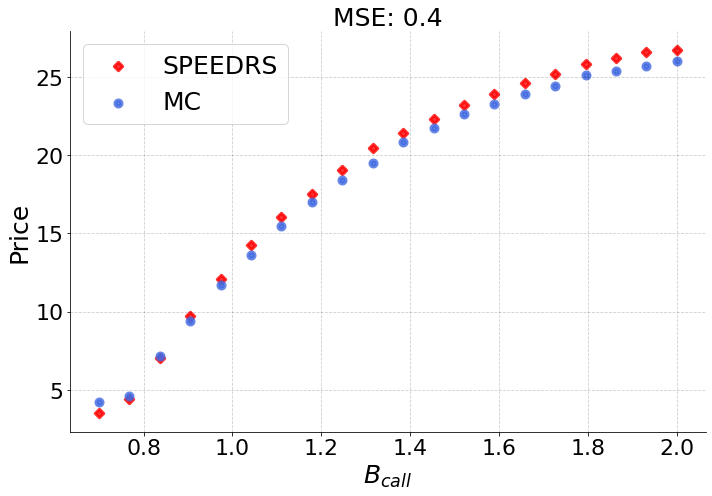

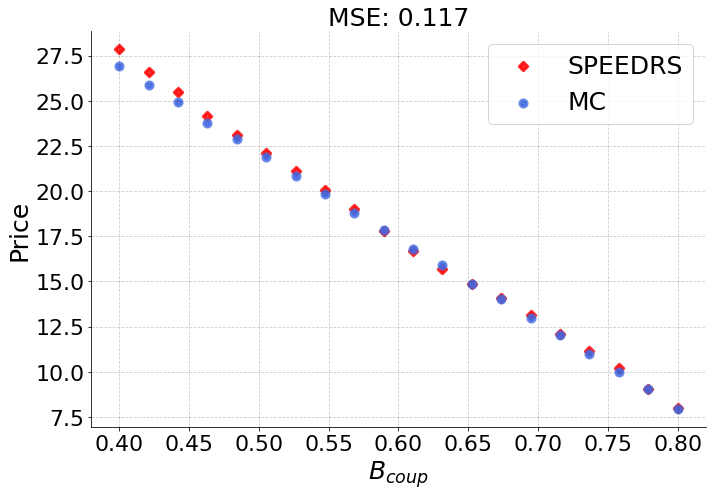

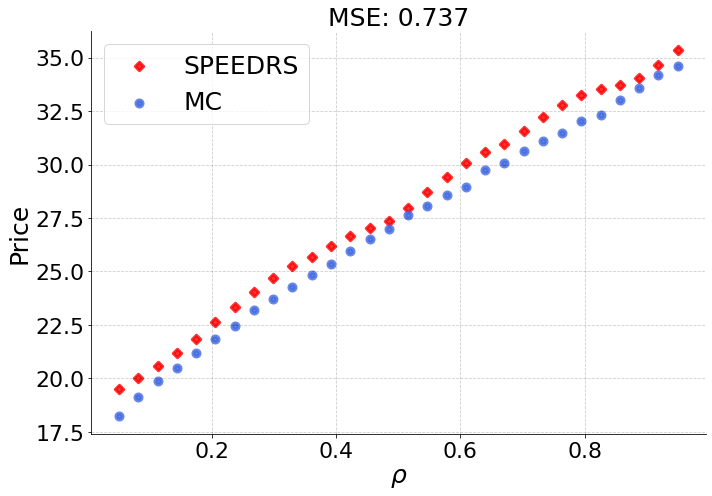

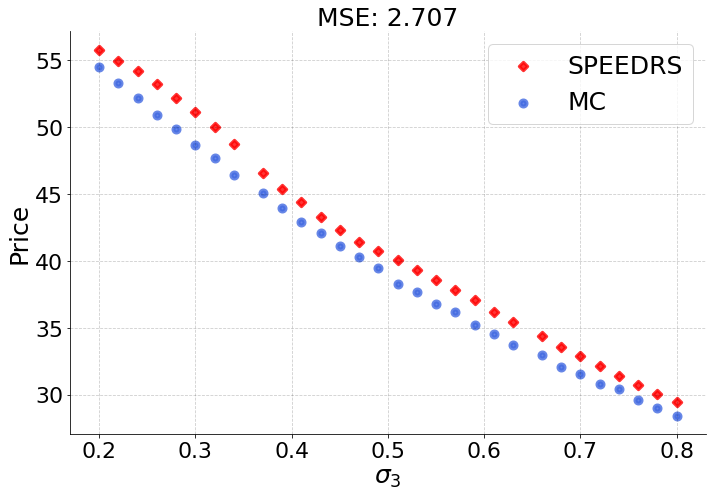

In [30]:
labels = ['SPEEDRS', 'MC']
markers = ['D', 'o']
alphas = [0.8, 0.8]
linewidths = [3.0, 4.0]
colors = ['red', 'royalblue']
ylabel = 'Price'

fig, ax = plt.subplots(figsize=(10, 7))


construct_scatter_plot(ax, test_data_dict['B_call'][0], test_data_dict['B_call'][1], test_data_dict['B_call'][2], 
                       labels, markers, colors, alphas, linewidths, r'$B_{call}$', ylabel)


plt.tight_layout()
filename = 'Multi GBM/Images/autocallable_test_plots_Bcall.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()


fig, ax = plt.subplots(figsize=(10, 7))


construct_scatter_plot(ax, test_data_dict['B_coup'][0], test_data_dict['B_coup'][1], test_data_dict['B_coup'][2], 
                       labels, markers, colors, alphas, linewidths, r'$B_{coup}$', ylabel)

plt.tight_layout()
filename = 'Multi GBM/Images/autocallable_test_plots_Bcoup.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

construct_scatter_plot(ax, test_data_dict['Correlation'][0], test_data_dict['Correlation'][1], test_data_dict['Correlation'][2], 
                       labels, markers, colors, alphas, linewidths, r'$\rho$', ylabel)

plt.tight_layout()
filename = 'Multi GBM/Images/autocallable_test_plots_rho.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

construct_scatter_plot(ax, test_data_dict['Sigma3'][0], test_data_dict['Sigma3'][1], test_data_dict['Sigma3'][2], 
                       labels, markers, colors, alphas, linewidths, r'$\sigma_3$', ylabel)

plt.tight_layout()
filename = 'Multi GBM/Images/autocallable_test_plots_sigma3.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

## Test Run-Time

In [ ]:
correlation = np.round(np.random.uniform(0.05, 0.95), 5)
sigmas = np.round(np.random.uniform(0.2, 0.8, dim), 5)

dim = 3

S0 = np.random.randint(80, 100, dim)

S_ref = np.random.randint(60, 85, dim)
r = 0.015

delta = 1
T_end = 5


Notionals = np.round(np.random.uniform(20, 30, 5), 2)
R = np.round(np.random.uniform(5, 15), 2)

B_coup = np.round(np.random.uniform(0.4, 0.8), 5)
B_gar = np.round(np.random.uniform(0.2, 0.6), 5)
B_call = np.round(np.random.uniform(0.7, 2), 5)

In [76]:
%%timeit 

price_autocallable_mc(S0, r, sigmas, correlation, S_ref, Notionals, T_end, B_gar, B_coup, B_call, R, delta,
                      200000)

48.4 s ± 5.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [175]:
%%timeit

multi_gbm_second_order_mmd_model.model.eval()
autocallable_pricing_model.model.eval()
with torch.no_grad():
    test_inputs = []
    for j in range(N):
        mmd_input = [sigmas[int(k/2)] if k%2 == 0 else multi_gbm_autocallable_dict['Sigma List'][j][int(k/2)]
                     for k in range(2*dim)]
        mmd_input += [correlation, multi_gbm_autocallable_dict['Correlation List'][j]]
        test_inputs.append(
            multi_gbm_second_order_mmd_model.transform(torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))


    for i in range(dim):
        test_inputs.append(S0[i])
        test_inputs.append(S_ref[i])
            
    for i in range(int(T_end/delta)):
        test_inputs.append(Notionals[i])
        
    test_inputs.append(R)


    test_inputs.append(B_gar)
    test_inputs.append(B_coup)
    test_inputs.append(B_call)

    autocallable_pricing_model.transform(torch.tensor(test_inputs).unsqueeze(0).float())

23.1 ms ± 5.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
